In [28]:
import os, warnings
import matplotlib.pyplot as plt
from matplotlib import gridspec

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Step 1: Load Data

In [2]:
# Reproducability
def set_seed(seed=31415):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed(31415)

In [3]:
# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')
warnings.filterwarnings("ignore") # to clean up output cells

In [4]:
# Load training and validation sets
ds_train_ = image_dataset_from_directory(
    './data/car-or-truck/train',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=True,
)
ds_valid_ = image_dataset_from_directory(
    './data/car-or-truck/train',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=False,
)

Found 5117 files belonging to 2 classes.


2023-08-22 16:46:54.945043: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-22 16:46:54.945429: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Found 5117 files belonging to 2 classes.


In [6]:
# Data Pipeline
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE
ds_train = (
    ds_train_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
ds_valid = (
    ds_valid_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

# Step 2: Define Pretrained Base

The most commonly used dataset for pretraining is ImageNet, a large dataset of many kind of natural images. Keras includes a variety models pretrained on ImageNet in its applications module. The pretrained model we'll use is called VGG16.

In [7]:
import matplotlib.pyplot as plt

In [9]:
pretrained_base = tf.keras.models.load_model(
    './data/cv-course-models/vgg16-pretrained-base',
)
pretrained_base.trainable = False

# Step 3: Attach Head 

Next, we attach the classifier head. For this example, we'll use a layer of hidden units (the first Dense layer) followed by a layer to transform the outputs to a probability score for class 1, Truck. The Flatten layer transforms the two dimensional outputs of the base into the one dimensional inputs needed by the head.

In [10]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    pretrained_base,
    layers.Flatten(),
    layers.Dense(6, activation='relu'),
    layers.Dense(1, activation='sigmoid'),
])

# Step 4 - Train
Finally, let's train the model. Since this is a two-class problem, we'll use the binary versions of crossentropy and accuracy. The adam optimizer generally performs well, so we'll choose it as well.

In [11]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)

history = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=30,
    verbose=0,
)

In [20]:
from datetime import datetime


'2023-08-22'

In [21]:
# Save the trained model
model.save(f"history_{str(datetime.now().date())}")

INFO:tensorflow:Assets written to: history_2023-08-22/assets


INFO:tensorflow:Assets written to: history_2023-08-22/assets


In [22]:
from tensorflow.keras.models import load_model

# Load the saved model
loaded_model = load_model("history_2023-08-22")

<Axes: >

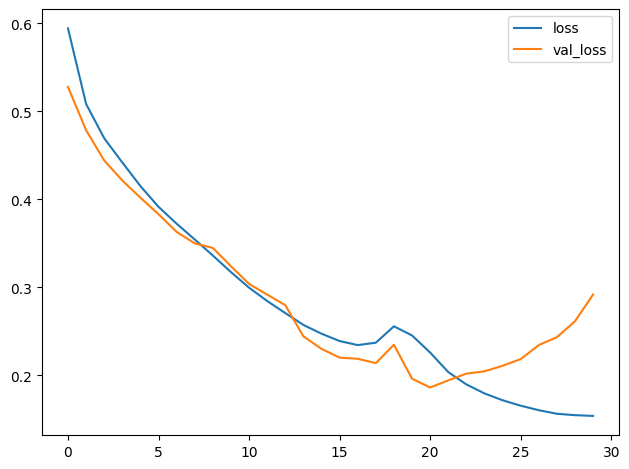

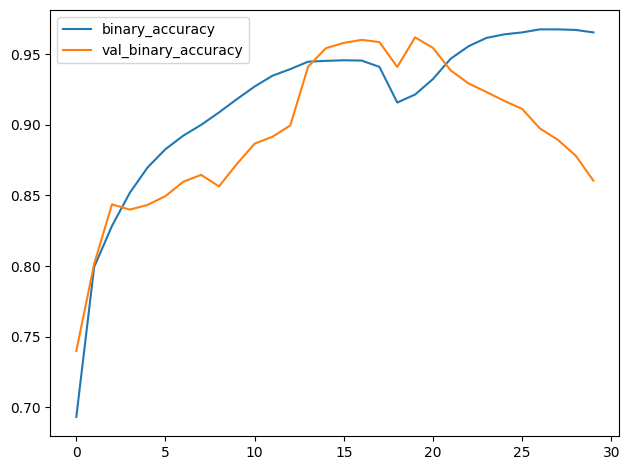

In [26]:
import pandas as pd

history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot()

In [27]:
history_frame

,loss,binary_accuracy,val_loss,val_binary_accuracy
0,0.594234,0.693180,0.527712,0.739887
1,0.508404,0.799296,0.478584,0.801446
2,0.469424,0.828415,0.444097,0.843658
3,0.441868,0.851866,0.421432,0.839945
4,0.415043,0.869846,0.401839,0.843268
5,0.391482,0.882744,0.383095,0.849521
6,0.372324,0.892320,0.363008,0.859683
7,0.354354,0.899941,0.349978,0.864569
8,0.336173,0.908736,0.344783,0.856361
9,0.317285,0.918116,0.323992,0.872191
